# Probabilistic Forecast Evaluation

> Hierarchical Forecast's reconciliation and evaluation.

This notebook offers a step to step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `HierarchicalForecast` and `StatsForecast` core class, to create base predictions, reconcile and evaluate them. 

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline
1. Installing Packages
2. Prepare TourismL dataset
    - Read and aggregate
    - StatsForecast's Base Predictions
3. Reconciliar
4. Evaluar

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismLarge-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing HierarchicalForecast

We assume you have StatsForecast and HierarchicalForecast already installed, if not 
check this guide for instructions on how to install HierarchicalForecast.

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast datasetsforecast

In [ ]:
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM

from hierarchicalforecast.utils import is_strictly_hierarchical
from hierarchicalforecast.utils import HierarchicalPlot, CodeTimer
from hierarchicalforecast.evaluation import scaled_crps, msse, energy_score

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

## 2. Preparing TourismL Dataset

### 2.1 Read Hierarchical Dataset

In [ ]:
# ['Labour', 'Traffic', 'TourismSmall', 'TourismLarge', 'Wiki2']
dataset = 'TourismSmall' # 'TourismLarge'
verbose = True
intervals_method = 'bootstrap'
LEVEL = np.arange(0, 100, 2)
# qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
# QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
with CodeTimer('Read and Parse data   ', verbose):
    print(f'{dataset}')
    if not os.path.exists('./data'):
        os.makedirs('./data')
    
    dataset_info = HierarchicalInfo[dataset]
    Y_df, S_df, tags = HierarchicalData.load(directory=f'./data/{dataset}', group=dataset)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    # Train/Test Splits
    horizon = dataset_info.horizon
    seasonality = dataset_info.seasonality
    Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(horizon)
    Y_train_df = Y_df.drop(Y_test_df.index)
    S_df = S_df.reset_index(names="unique_id")

TourismSmall


100%|██████████| 1.30M/1.30M [00:00<00:00, 2.22MiB/s]
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 1297274, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed data\TourismSmall\hierarchical\datasets.zip


Code block 'Read and Parse data   ' took:	1.03073 seconds


In [ ]:
dataset_info.seasonality

4

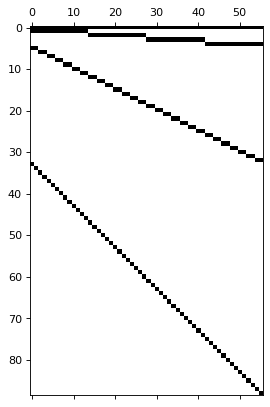

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [ ]:
Y_train_df

,unique_id,ds,y
0,total,1998-03-31,84503
1,total,1998-06-30,65312
2,total,1998-09-30,72753
3,total,1998-12-31,70880
4,total,1999-03-31,86893
...,...,...,...
3191,nt-oth-noncity,2003-12-31,132
3192,nt-oth-noncity,2004-03-31,12
3193,nt-oth-noncity,2004-06-30,40
3194,nt-oth-noncity,2004-09-30,186


### 2.2 StatsForecast's Base Predictions

This cell computes the base predictions `Y_hat_df` for all the series in `Y_df` using StatsForecast's `AutoARIMA`.
Additionally we obtain insample predictions `Y_fitted_df` for the methods that require them.

In [ ]:
%%capture
with CodeTimer('Fit/Predict Model     ', verbose):
    # Read to avoid unnecesary AutoARIMA computation
    yhat_file = f'./data/{dataset}/Y_hat.csv'
    yfitted_file = f'./data/{dataset}/Y_fitted.csv'

    if os.path.exists(yhat_file):
        Y_hat_df = pd.read_csv(yhat_file, parse_dates=['ds'])
        Y_fitted_df = pd.read_csv(yfitted_file, parse_dates=['ds'])

    else:
        fcst = StatsForecast(
            models=[AutoARIMA(season_length=seasonality)],
            fallback_model=[Naive()],
            freq=dataset_info.freq, 
            n_jobs=-1
        )
        Y_hat_df = fcst.forecast(df=Y_train_df, h=horizon, fitted=True, level=LEVEL)
        Y_fitted_df = fcst.forecast_fitted_values()
        Y_hat_df.to_csv(yhat_file, index=False)
        Y_fitted_df.to_csv(yfitted_file, index=False)

## 3. Reconcile Predictions

In [ ]:
with CodeTimer('Reconcile Predictions ', verbose):
    if is_strictly_hierarchical(S=S_df.drop(columns="unique_id").values.astype(np.float32), tags={key: S_df["unique_id"].isin(val).values.nonzero()[0] for key, val in tags.items()}):
        reconcilers = [
            BottomUp(),
            TopDown(method='average_proportions'),
            TopDown(method='proportion_averages'),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            ERM(method='closed')
        ]
    else:
        reconcilers = [
            BottomUp(),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            ERM(method='closed')
        ]
    
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    Y_rec_df = hrec.bootstrap_reconcile(Y_hat_df=Y_hat_df,
                                        Y_df=Y_fitted_df,
                                        S_df=S_df, tags=tags,
                                        level=LEVEL,
                                        intervals_method=intervals_method,
                                        num_samples=10, 
                                        num_seeds=10)
    
    Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how="left")

Code block 'Reconcile Predictions ' took:	7.46115 seconds


Qualitative evaluation, of parsed quantiles


<matplotlib.legend.Legend>

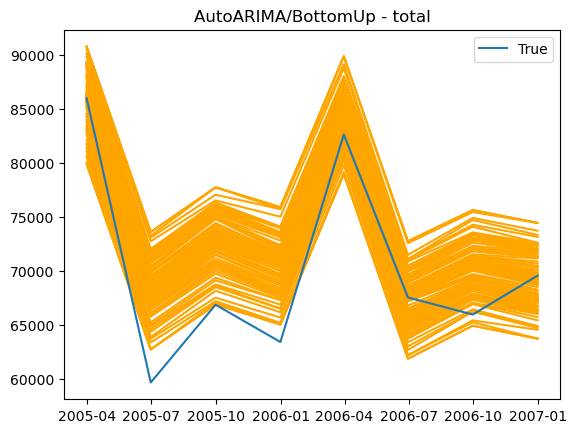

In [ ]:
unique_id = "total"
plot_df = Y_rec_df.query("unique_id == @unique_id").groupby(["unique_id", "ds"], as_index=False).mean()
for col in hrec.level_names['AutoARIMA/BottomUp']:
    plt.plot(plot_df["ds"], plot_df[col], color="orange")
plt.plot(plot_df["ds"], plot_df["y"], label="True")
plt.title(f"AutoARIMA/BottomUp - {unique_id}")
plt.legend()

## 4. Evaluation

In [ ]:
from utilsforecast.losses import scaled_crps
from hierarchicalforecast.evaluation import evaluate

In [ ]:
with CodeTimer('Evaluate Models CRPS  ', verbose):
    crps_seeds = []
    for seed in Y_rec_df.seed.unique():
        df_seed = Y_rec_df.query("seed == @seed")
        crps_results_seed = evaluate(df = df_seed,
                            tags = tags,
                            metrics = [scaled_crps],
                            models= hrec.level_names.keys(),
                            level = LEVEL,
                            )
        crps_results_seed['seed'] = seed
        crps_seeds.append(crps_results_seed)
    crps_seeds = pd.concat(crps_seeds)

    crps_mean = crps_seeds.groupby(["level", "metric"], as_index=False).mean()
    crps_std = crps_seeds.groupby(["level", "metric"], as_index=False).std()

    crps_results = crps_mean[hrec.level_names.keys()].round(3).astype(str) + "±" + crps_std[hrec.level_names.keys()].round(4).astype(str)
    crps_results.insert(0, "metric", crps_mean["metric"])
    crps_results.insert(0, "level", crps_mean["level"])

crps_results

Code block 'Evaluate Models CRPS  ' took:	4.62986 seconds


,level,metric,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-average_proportions,AutoARIMA/TopDown_method-proportion_averages,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,Country,scaled_crps,0.043±0.0009,0.048±0.0006,0.048±0.0006,0.05±0.0006,0.051±0.0006,0.053±0.0006,0.054±0.0009
1,Country/Purpose,scaled_crps,0.077±0.001,0.114±0.0003,0.112±0.0004,0.09±0.0013,0.087±0.0009,0.089±0.0009,0.106±0.0013
2,Country/Purpose/State,scaled_crps,0.165±0.0009,0.249±0.0004,0.247±0.0004,0.18±0.0018,0.169±0.0009,0.169±0.0008,0.231±0.0021
3,Country/Purpose/State/CityNonCity,scaled_crps,0.218±0.0013,0.289±0.0004,0.286±0.0004,0.228±0.0018,0.217±0.0013,0.218±0.0011,0.302±0.0033
4,Overall,scaled_crps,0.193±0.0011,0.266±0.0004,0.263±0.0004,0.205±0.0017,0.194±0.0011,0.195±0.0009,0.268±0.0027


## References

- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
\"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022). 
"Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". 
Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)